In [ ]:
!pip install datasets

In [163]:
import os
import pandas as pf
from datasets import load_dataset

from PIL import Image, ImageDraw, ImageFont

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, GPT2Tokenizer, Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset, random_split

import requests

### Classes

In [184]:
class cfg :
    ENCODER = "microsoft/swin-tiny-patch4-window7-224"
    DECODER = "gpt2"

    MAX_LEN = 16

    OUTPUT_DIR = "./runs"
    LOG_DIR = "./logs"

    EPOCHS = 5
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    SAVE_STEPS = 10_000

    LR = 5e-5

In [185]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["input_ids"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

### Dataset

In [ ]:
images_dataset = load_dataset("flickr8k")

In [ ]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip" -O Flickr8k_text.zip
!unzip Flickr8k_text.zip -d Flickr8k_text

In [61]:
!cp Flickr8k_text/Flickr8k.token.txt ./captions.txt
!rm -r -f Flickr8k_text

In [66]:
captions = []
raw_captions = open("captions.txt", "r").read()
raw_captions = raw_captions.split("\n")
for c in raw_captions:
  if "#0" in c:
    captions.append(c.split("\t")[1])

In [145]:
class Flickr8kDataset(Dataset):
    def __init__(self, flicker_images, captions, feature_extractor, tokenizer, max_length):
        self.images = flicker_images["train"]
        self.captions = captions
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        return self.feature_extractor(images=image, return_tensors="pt").pixel_values[0]

    def preprocess_text(self, text):
        return self.tokenizer(text, max_length=self.max_length, padding="max_length", truncation=True).input_ids

    def __getitem__(self, idx):
        image = self.images[idx]["image"]
        caption = self.captions[idx]
        pixel_values = self.preprocess_image(image)
        input_ids = self.preprocess_text(caption)
        return {"pixel_values": pixel_values, "input_ids": input_ids}

### Train

In [125]:
device = torch.device("cuda:0")

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(cfg.ENCODER, cfg.DECODER, device_map="auto", tie)

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(cfg.ENCODER)
tokenizer = GPT2Tokenizer.from_pretrained(cfg.DECODER)

In [149]:
tokenizer.pad_token = tokenizer.eos_token

In [153]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.decoder.config.vocab_size
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.max_length = cfg.MAX_LEN
model.config.no_repeat_ngram_size = 2

In [154]:
training_args = TrainingArguments(
    output_dir= cfg.OUTPUT_DIR,
    eval_strategy="epoch",
    per_device_train_batch_size= cfg.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size= cfg.VAL_BATCH_SIZE,
    num_train_epochs= cfg.EPOCHS,
    save_steps= cfg.SAVE_STEPS,
    logging_dir= cfg.LOG_DIR,
    learning_rate= cfg.LR,
    remove_unused_columns= False
)

In [155]:
dataset = Flickr8kDataset(images_dataset, captions, feature_extractor, tokenizer, cfg.MAX_LEN)
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])

In [158]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn
)

In [159]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.861400,2.191574
2,1.796800,2.191162
3,1.515800,2.331289
4,1.250500,2.539540
5,1.051600,2.696292


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 16, 'no_repeat_ngram_size': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


TrainOutput(global_step=4555, training_loss=1.4894185506944206, metrics={'train_runtime': 1401.6439, 'train_samples_per_second': 25.977, 'train_steps_per_second': 3.25, 'total_flos': 4.63479226059903e+18, 'train_loss': 1.4894185506944206, 'epoch': 5.0})

### Test


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/AUB Research/VIP/checkpoint-4555")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

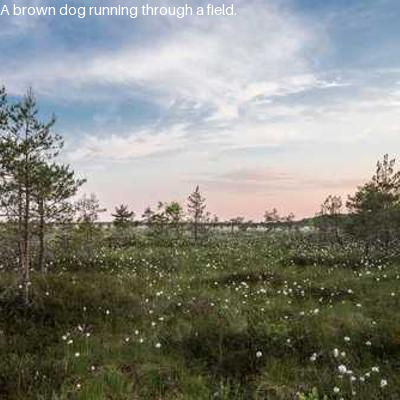

In [192]:
image_url = "https://picsum.photos/400"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
output_ids = model.generate(pixel_values, max_length=16, num_beams=4, repetition_penalty=2.5)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default(15)
draw.text((0, 0), caption ,(255,255,255),font=font)

image

In [ ]:
def generate_caption(image_url):

